In [1]:
!pwd

/data/fetalai


In [2]:
from fastai.vision.all import *

In [3]:
# Define the root directory for the dataset
dataroot_dir = Path('dataset')

# Define labeled and unlabeled directories based on dataroot
labeled_dataroot_dir = dataroot_dir/'labeled_data'
unlabeled_dataroot_dir = dataroot_dir/'unlabeled_data'

In [4]:
dataroot_dir.ls(), labeled_dataroot_dir.ls(), unlabeled_dataroot_dir.ls()

((#4) [Path('dataset/Data-sharing Agreement_FUGC2025.docx'),Path('dataset/.ipynb_checkpoints'),Path('dataset/labeled_data'),Path('dataset/unlabeled_data')],
 (#3) [Path('dataset/labeled_data/images'),Path('dataset/labeled_data/.ipynb_checkpoints'),Path('dataset/labeled_data/labels')],
 (#3) [Path('dataset/unlabeled_data/images'),Path('dataset/unlabeled_data/.ipynb_checkpoints'),Path('dataset/unlabeled_data/labels')])

In [5]:
# Define class codes for segmentation
class_codes = ['background', 'anterior', 'posterior']  # Ensure correct class mappings

# Image and mask transformations
item_tfms = [Resize((256, 256), method='nearest')]  # Resize masks with nearest neighbor
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

# Function to get the mask path from the image path
def get_y(image_path):
    return Path(str(image_path).replace("images", "labels"))

In [9]:
# Labeled DataBlock (Multi-class Segmentation)
labeled_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_codes)),  # Multi-class segmentation
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,  # Map image path to corresponding mask
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Create labeled DataLoaders
labeled_dls = labeled_block.dataloaders(labeled_dataroot_dir/'images', bs=8, shuffle=True)

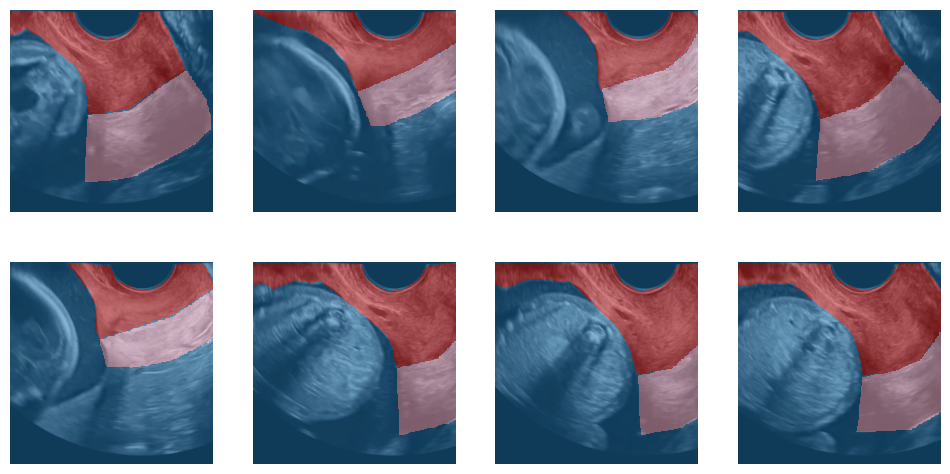

In [10]:
labeled_dls.show_batch()

In [13]:
# Unlabeled DataBlock (for inference)
unlabeled_block = DataBlock(
    blocks=(ImageBlock,),  # Only images, no labels
    get_items=get_image_files,
    splitter=None,  # No splitting needed
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Create unlabeled DataLoaders
unlabeled_dls = unlabeled_block.dataloaders(unlabeled_dataroot_dir/'images', bs=8, shuffle=True)

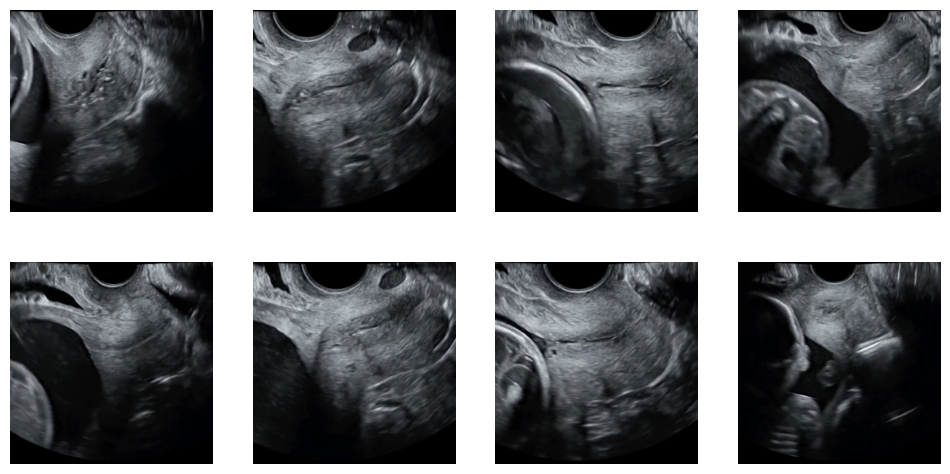

In [14]:
unlabeled_dls.show_batch()

In [17]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

NameError: name 'act_gr' is not defined